# Introduction to Deep Learning - Week 4: Kaggle Mini Project

# **NATURAL LANGUAGE PROCESSING WITH DISASTER TWEETS**

# **1. Description of the Problem and Data**

This project focuses on developing a model that can automatically classify tweets as either related to real disasters or not.<br>
The task is framed as a binary classification problem, where each tweet is labeled as **1** if it refers to a real disaster and **0** if it does not. To solve this, we will build an artificial neural network capable of learning from text data and predicting the correct label.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 4000
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow.keras as keras
import time
import os
import itertools
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, LSTM, Embedding, Dropout
from keras.optimizers import Adam, RMSprop
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

2025-06-06 14:03:26.284894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749218606.557069      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749218606.639912      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The dataset used in this project contains a collection of tweets, each accompanied by additional contextual information. Specifically, each sample includes:

* The full text of the tweet
* A keyword extracted from the tweet
* The location from which the tweet was sent

The data is organized across three CSV files:

* train.csv – the training dataset, which includes both the tweet data and the corresponding labels
* test.csv – similar to the training set but without the labels, used for making predictions
* sample\_submission.csv – a reference file showing the correct format for submission of predicted results

In [2]:
# Load train and test data
dir_train = '/kaggle/input/nlp-getting-started/train'
dir_test = '/kaggle/input/nlp-getting-started/test'

# **2. Exploratory Data Analysis and Data Preprocessing**

Let's start by examining the train csv file.<br>
As we can see below, the table contains 7613 rows and the following five columns:
* **id** – a unique identifier for each tweet
* **keyword** – a relevant keyword extracted from the tweet (may be missing)
* **location** – the user-specified location where the tweet was posted (may be missing)
* **text** – the content of the tweet
* **target** – indicates whether the tweet is about a real disaster (1) or not (0)

In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_train.info()
df_train.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


To better understand the role of keywords in our dataset, we analyzed the top 20 most frequent keywords separately for tweets labeled as disasters and non-disasters. However, this comparison revealed that many keywords appear ambiguous and do not clearly distinguish between the two categories.

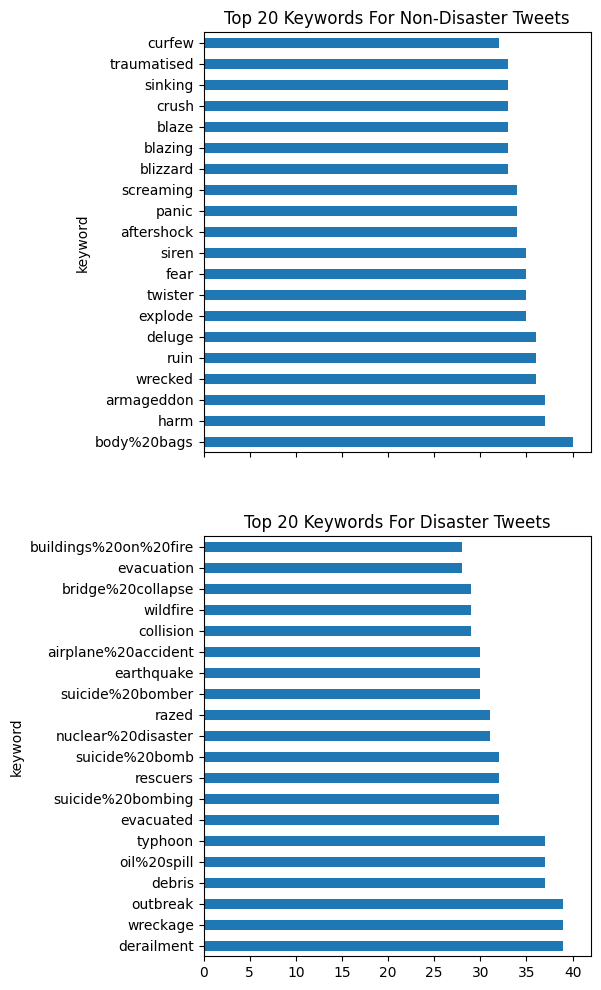

In [4]:
# Top 20 keywords
fig, ax = plt.subplots(2, 1, figsize=(5, 12), sharex=True)

df_train[df_train.target == 0].keyword.value_counts()[:20].plot(kind='barh', title='Top 20 Keywords For Non-Disaster Tweets', ax=ax[0])
df_train[df_train.target == 1].keyword.value_counts()[:20].plot(kind='barh', title='Top 20 Keywords For Disaster Tweets', ax=ax[1])

plt.show()

These charts highlight the difficulty in defining what constitutes a “disaster” keyword. The overlap and ambiguity between the top keywords in both categories suggest that this feature lacks discriminative power for our classification task.<br>
As a result, we decided to drop the `keyword` column from our dataset. Additionally, we also removed the `id` and `location` columns, as they do not contribute meaningful information for the analysis or model training.

In [5]:
# Remove 'id', 'location' and 'keyword' columns
df_train = df_train.drop(columns=['id', 'keyword','location'])
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Now, let's check for duplicate tweet texts.

In [6]:
# Find duplicates
df_train[df_train.text.duplicated() == True]

,text,target
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,Experts in France begin examining airplane deb...,1
624,To fight bioterrorism sir.,0
630,To fight bioterrorism sir.,1
634,To fight bioterrorism sir.,0
1156,Japan on Thursday marks the 70th anniversary o...,1
1251,#TweetLikeItsSeptember11th2001 Those two build...,1
1331,Mmmmmm I'm burning.... I'm burning buildings I...,0


In [7]:
# Remove duplicates
df_train = df_train.drop_duplicates(subset=['text'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7503 non-null   object
 1   target  7503 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 175.9+ KB


We found 110 duplicates in total. These were removed to ensure the uniqueness and integrity of the dataset.

With the dataset now cleaned, I proceeded to examine the distribution of labels. The results showed a slightly imbalanced dataset, with approximately 57% of the tweets labeled as non-disaster (0) and 43% as disaster-related (1).

Non-Disaster Tweet Count = 4305
Disaster Tweet Count = 3198


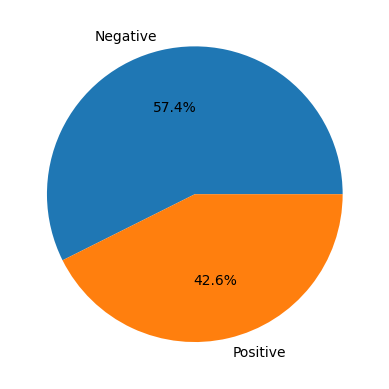

In [8]:
# Label count
label_count = df_train['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

print(f"Non-Disaster Tweet Count = {label_count[0]}")
print(f"Disaster Tweet Count = {label_count[1]}")

plt.show()

# **3. Model Architecture and Analysis**

Before feeding the data into our model, we perform a series of text-cleaning steps to standardize and simplify the input. This is done through a function that includes the following operations:

* Removal of non-English characters to reduce noise
* Conversion to lowercase to ensure uniformity
* Trimming of trailing white spaces
* Elimination of stop words (articles, prepositions, pronouns, conjunctions) which typically do not contribute meaningful information for classification
* Stemming, which reduces words to their base or root form to treat similar words as equivalent

These steps help clean and normalize the tweet text, making it more suitable for training the model.<br>
After cleaning, we apply tokenization and finally we perform padding, which ensures that all token sequences have the same length by adding zeroes to the end of shorter sequences. This normalization is essential for consistent input dimensions in the neural network.

In [9]:
def text_cleaner(var):
    sw = set(stopwords.words('english'))
    ps = PorterStemmer() 

    # tokenize the word using nltk  
    my_text = nltk.word_tokenize(var)

    # remove not english characters, lower case and remove the white space at end 
    my_text = re.sub('[^A-Za-z0-9]+', " ", var).lower().strip()

    # remove stop words 
    my_text = [word for word in my_text.split() if word not in sw]

    # stemming
    my_text = [ps.stem(word) for word in my_text]

    # convert back to sentence
    my_text = ' '.join(my_text)

    return my_text

In [10]:
df_train['text'] = df_train['text'].apply(text_cleaner)
df_train.head()

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13 000 peopl receiv wildfir evacu order califo...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1


In [11]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text.values)
df_train['tokenized'] = tokenizer.texts_to_sequences(df_train.text.values)
data_train_token = df_train.tokenized
data_train_token

0                    [3806, 488, 230, 97, 1694, 3037, 43]
1                    [150, 4, 205, 575, 5489, 5490, 1070]
2       [1404, 541, 1695, 433, 5491, 224, 42, 1695, 43...
3                 [686, 2540, 14, 2541, 107, 42, 344, 48]
4        [60, 1071, 146, 3807, 1531, 220, 107, 2542, 139]
                              ...                        
7604    [1160, 2177, 1879, 1254, 400, 1525, 206, 4, 57...
7605        [2342, 502, 2421, 7, 195, 42, 422, 1268, 998]
7606    [59, 204, 15, 243, 320, 427, 503, 401, 629, 9,...
7608    [74, 708, 1052, 550, 329, 58, 572, 32, 2, 1, 1...
7612    [183, 32, 412, 179, 48, 107, 569, 13, 2, 1, 18...
Name: tokenized, Length: 7503, dtype: object

In [12]:
# Padding
data_train_token = pad_sequences(data_train_token, maxlen = 50, padding = 'post')
data_train_token

array([[3806,  488,  230, ...,    0,    0,    0],
       [ 150,    4,  205, ...,    0,    0,    0],
       [1404,  541, 1695, ...,    0,    0,    0],
       ...,
       [  59,  204,   15, ...,    0,    0,    0],
       [  74,  708, 1052, ...,    0,    0,    0],
       [ 183,   32,  412, ...,    0,    0,    0]], dtype=int32)

Now we divide the training dataset into a training and validation set.

In [13]:
# Train and validation set split
x_train, x_val, y_train, y_val = train_test_split(data_train_token, df_train.target.values, test_size = 0.2, random_state=56)

# Reshape
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_train.shape

(6002, 1)

In [14]:
word2idx = tokenizer.word_index
num_words = len(tokenizer.word_index)
print('Found', num_words, 'unique tokens')

Found 18432 unique tokens


# Model 1

For the first model, I’ve chosen to implement a Long Short-Term Memory (LSTM) network.

Traditional Recurrent Neural Networks (RNNs) tend to lose information over time due to the sequential nature of their processing: each time step slightly distorts the signal, and after enough steps, the model retains little memory of the earlier inputs. To address this limitation, architectures like LSTM were developed.

LSTM units are designed specifically to handle long-term dependencies. They are capable of identifying and retaining important inputs in a dedicated memory cell, preserving them across time steps, and recalling them when needed. This ability to manage information over longer sequences makes LSTMs especially effective at recognizing patterns in text data.

We can start with the following configuration:<br>
Input - LSTM - LSTM - Dense Layer (ReLU) - Dense Layer (Sigmoid)

This first model will use Adam optimization and binary cross-entropy to compute the loss with a training phase of 15 epochs.

In [15]:
model1 = Sequential()
model1.add(Embedding(input_dim = num_words +1, output_dim = 32, input_length = 50))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32))
model1.add(Dense(units = 24, activation = 'relu'))
model1.add(Dense(units = 1, activation = 'sigmoid'))

model1.build(input_shape = (None, 50))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-06 14:10:40.276360: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 32)              │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 627,921 (2.40 MB)

 Trainable params: 627,921 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
opt = Adam()
model1_epochs = 15

model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
startTime1 = time.time()
history1 = model1.fit(x_train, y_train, epochs = model1_epochs, validation_data = [x_val, y_val])
endTime1 = time.time()

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5704 - loss: 0.6850 - val_accuracy: 0.5670 - val_loss: 0.6846
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.6030 - loss: 0.6590 - val_accuracy: 0.5670 - val_loss: 0.6843
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5840 - loss: 0.6797 - val_accuracy: 0.5670 - val_loss: 0.6848
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5777 - loss: 0.6819 - val_accuracy: 0.6056 - val_loss: 0.6588
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7467 - loss: 0.5396 - val_accuracy: 0.7655 - val_loss: 0.5361
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8559 - loss: 0.3659 - val_accuracy: 0.7615 - val_loss: 0.4974
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9130 - loss: 0.2674 - val_accuracy: 0.7748 - val_loss: 0.5830
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9317 - loss: 0.2194 - val_acc

**MODEL 1 RESULTS**

In [18]:
def plot_history(hist, start_time=0, end_time=0):
    model_accuracy = round((hist["accuracy"][model_epochs - 1]), 3)
    model_loss = round((hist["loss"][model_epochs - 1]), 3)
    model_val_accuracy = round((hist["val_accuracy"][model_epochs - 1]), 3)
    model_val_loss = round((hist["val_loss"][model_epochs - 1]), 3)
    model_train_time = round((end_time - start_time) / 60, 3)
    
    print("The final results for model:")
    print(f"\nTraining Time = {model_train_time} minutes")
    print(f"Accuracy = {model_accuracy}")
    print(f"Loss = {model_loss}")
    print(f"Validation Accuracy = {model_val_accuracy}")
    print(f"Validation Loss = {model_val_loss}\n\n")
    
    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(2, 2)
    figure.tight_layout(pad = 2)
    figure.set_figheight(15)
    figure.set_figwidth(15)
    
    # Training Accuracy Vs. Epoch
    testAccs = hist["accuracy"]
    epochs = [i for i in range(len(testAccs))]
    axis[0, 0].plot(epochs, testAccs)
    axis[0, 0].set_xlabel("Epoch")
    axis[0, 0].set_ylabel("Training Accuracy")
    axis[0, 0].set_title("Training Accuracy Vs. Epoch")
    
    # Loss Vs. Epoch
    testLosses = hist["loss"]
    axis[0, 1].plot(epochs, testLosses)
    axis[0, 1].set_xlabel("Epoch")
    axis[0, 1].set_ylabel("Training Loss")
    axis[0, 1].set_title("Training Loss Vs. Epoch")
    
    # Validation Accuracy Vs. Epoch
    testAccs = hist["val_accuracy"]
    epochs = [i for i in range(len(testAccs))]
    axis[1, 0].plot(epochs, testAccs)
    axis[1, 0].set_xlabel("Epoch")
    axis[1, 0].set_ylabel("Validation Accuracy")
    axis[1, 0].set_title("Validation Accuracy Vs. Epoch")
    
    # Validation Loss Vs. Epoch
    testLosses = hist["val_loss"]
    axis[1, 1].plot(epochs, testLosses)
    axis[1, 1].set_xlabel("Epoch")
    axis[1, 1].set_ylabel("Validation Loss")
    axis[1, 1].set_title("Validation Loss Vs. Epoch")
    
    plt.show

The final results for model:

Training Time = 1.981 minutes
Accuracy = 0.975
Loss = 0.076
Validation Accuracy = 0.75
Validation Loss = 0.855




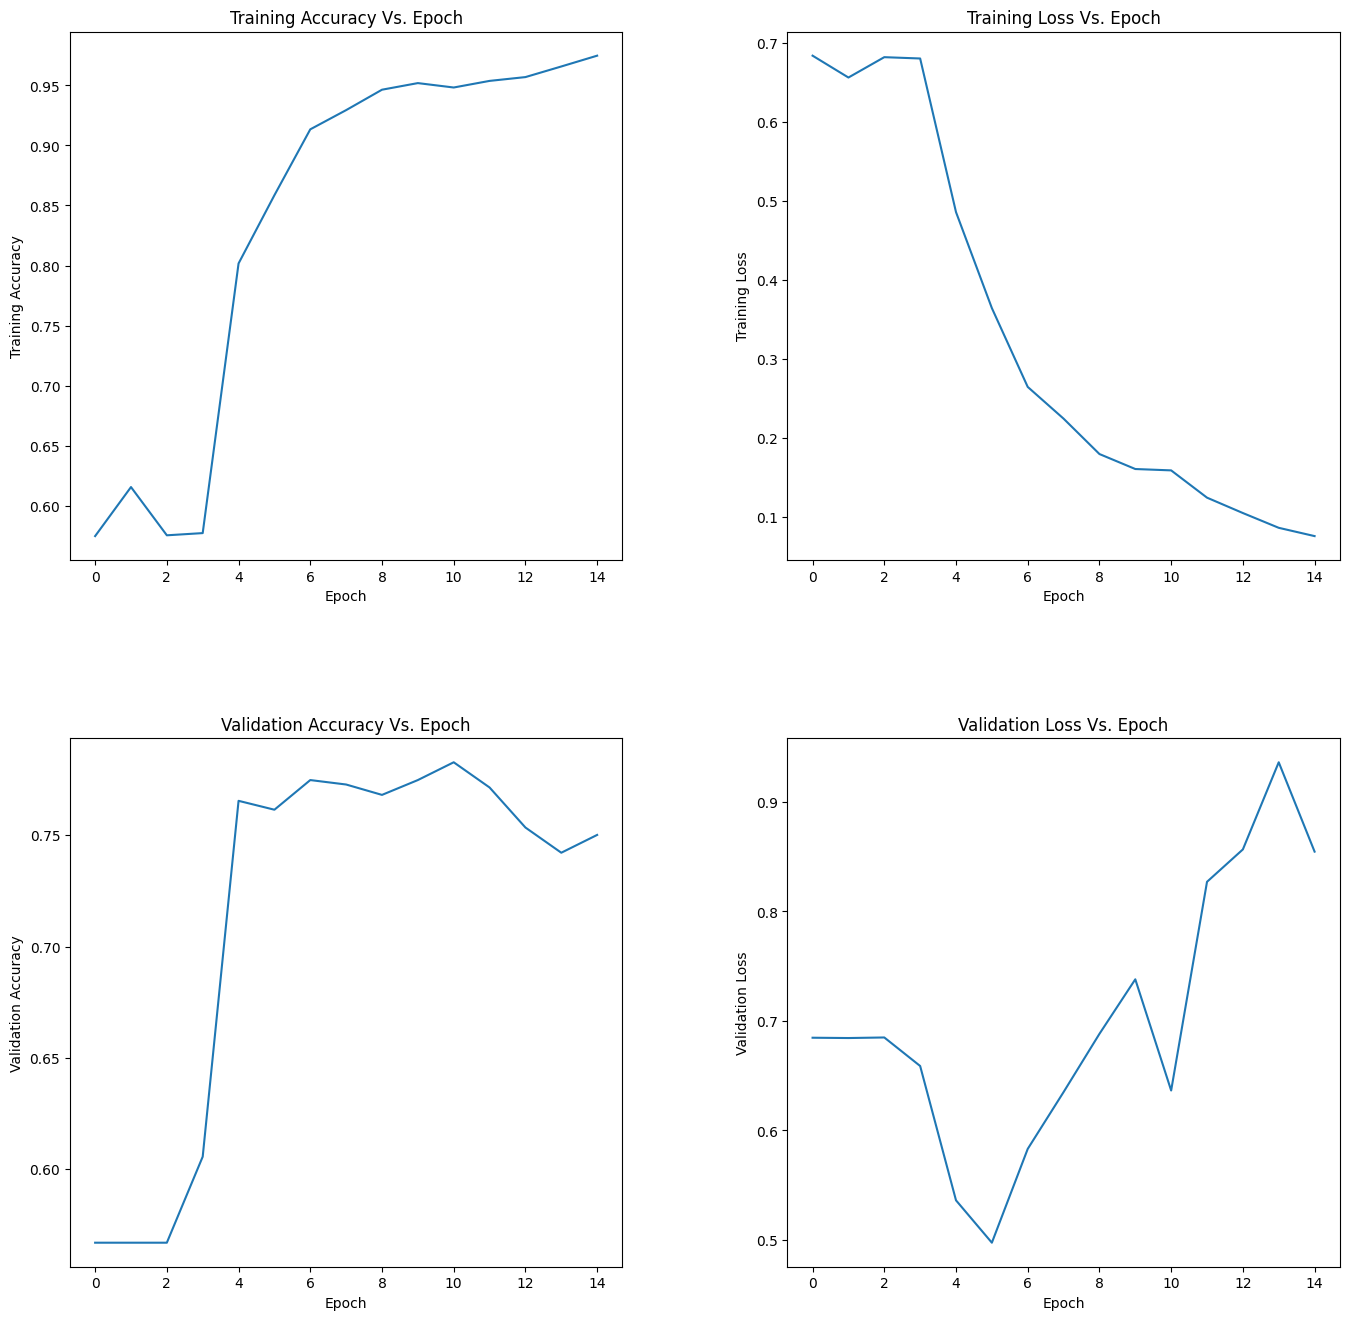

In [19]:
model_epochs=model1_epochs
plot_history(history1.history, startTime1, endTime1)

The training performance appears to be promising at first glance. Training accuracy rises consistently, eventually reaching about 91.8%, while the training loss gradually decreases, suggesting the model is learning fairly well from the training data.

However, things look less encouraging on the validation set. The validation accuracy remains flat, settling at 73%, while the validation loss continues to increase throughout the epochs.

This contrast between training and validation metrics could be seen as a sign of overfitting, i.e. the model is capturing the training data too well but failing to generalize to unseen data.

# Model 2

In order to help improve generalization and reduce the risk of overfitting, batch normalization layers are added after each LSTM unit. In this model, these layers help stabilize and accelerate training by normalizing the outputs of the LSTM cells.

Additionally, a dropout layer is introduced between the two dense layers in the artificial neural network. This layer randomly deactivates a fraction of the neurons during training, encouraging the model to rely less on specific paths and promotes better generalization.

At the start of the ANN, a flatten layer was included to convert the multi-dimensional output of the LSTM into a one-dimensional vector suitable for input into the dense layers.

This model is using Adam optimization as well and binary cross-entropy for loss, with a training phase of 15 epochs.

In [20]:
model2 = Sequential()
model2.add(Embedding(input_dim = num_words+1, output_dim = 32))
model2.add(LSTM(64, return_sequences = True))

# Normalize to prevent overfitting
model2.add(BatchNormalization())
model2.add(LSTM(32))

# Normalize to prevent overfitting
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(units = 24, activation = 'relu'))

# Dropout layer randomly sets input units to 0 which helps prevent overfitting
model2.add(Dropout(0.25))
model2.add(Dense(units = 1, activation = 'sigmoid'))

model2.build(input_shape=(None, 50))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 32)              │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,305 (2.40 MB)

 Trainable params: 628,113 (2.40 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
opt = Adam()
model2_epochs = 15
model2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
startTime2 = time.time()
history2 = model2.fit(x_train, y_train, epochs = model2_epochs, validation_data = [x_val, y_val])
endTime2 = time.time()

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.6723 - loss: 0.5991 - val_accuracy: 0.4330 - val_loss: 0.7180
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8958 - loss: 0.2861 - val_accuracy: 0.4330 - val_loss: 0.7671
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9491 - loss: 0.1649 - val_accuracy: 0.6216 - val_loss: 1.0252
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9691 - loss: 0.0995 - val_accuracy: 0.5183 - val_loss: 1.3882
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9801 - loss: 0.0691 - val_accuracy: 0.4330 - val_loss: 4.0698
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9852 - loss: 0.0581 - val_accuracy: 0.7109 - val_loss: 2.3767
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9820 - loss: 0.0568 - val_accuracy: 0.7275 - val_loss: 0.9343
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9929 - loss: 0.0241 - val_acc

The final results for model:

Training Time = 2.16 minutes
Accuracy = 0.998
Loss = 0.011
Validation Accuracy = 0.57
Validation Loss = 1.596




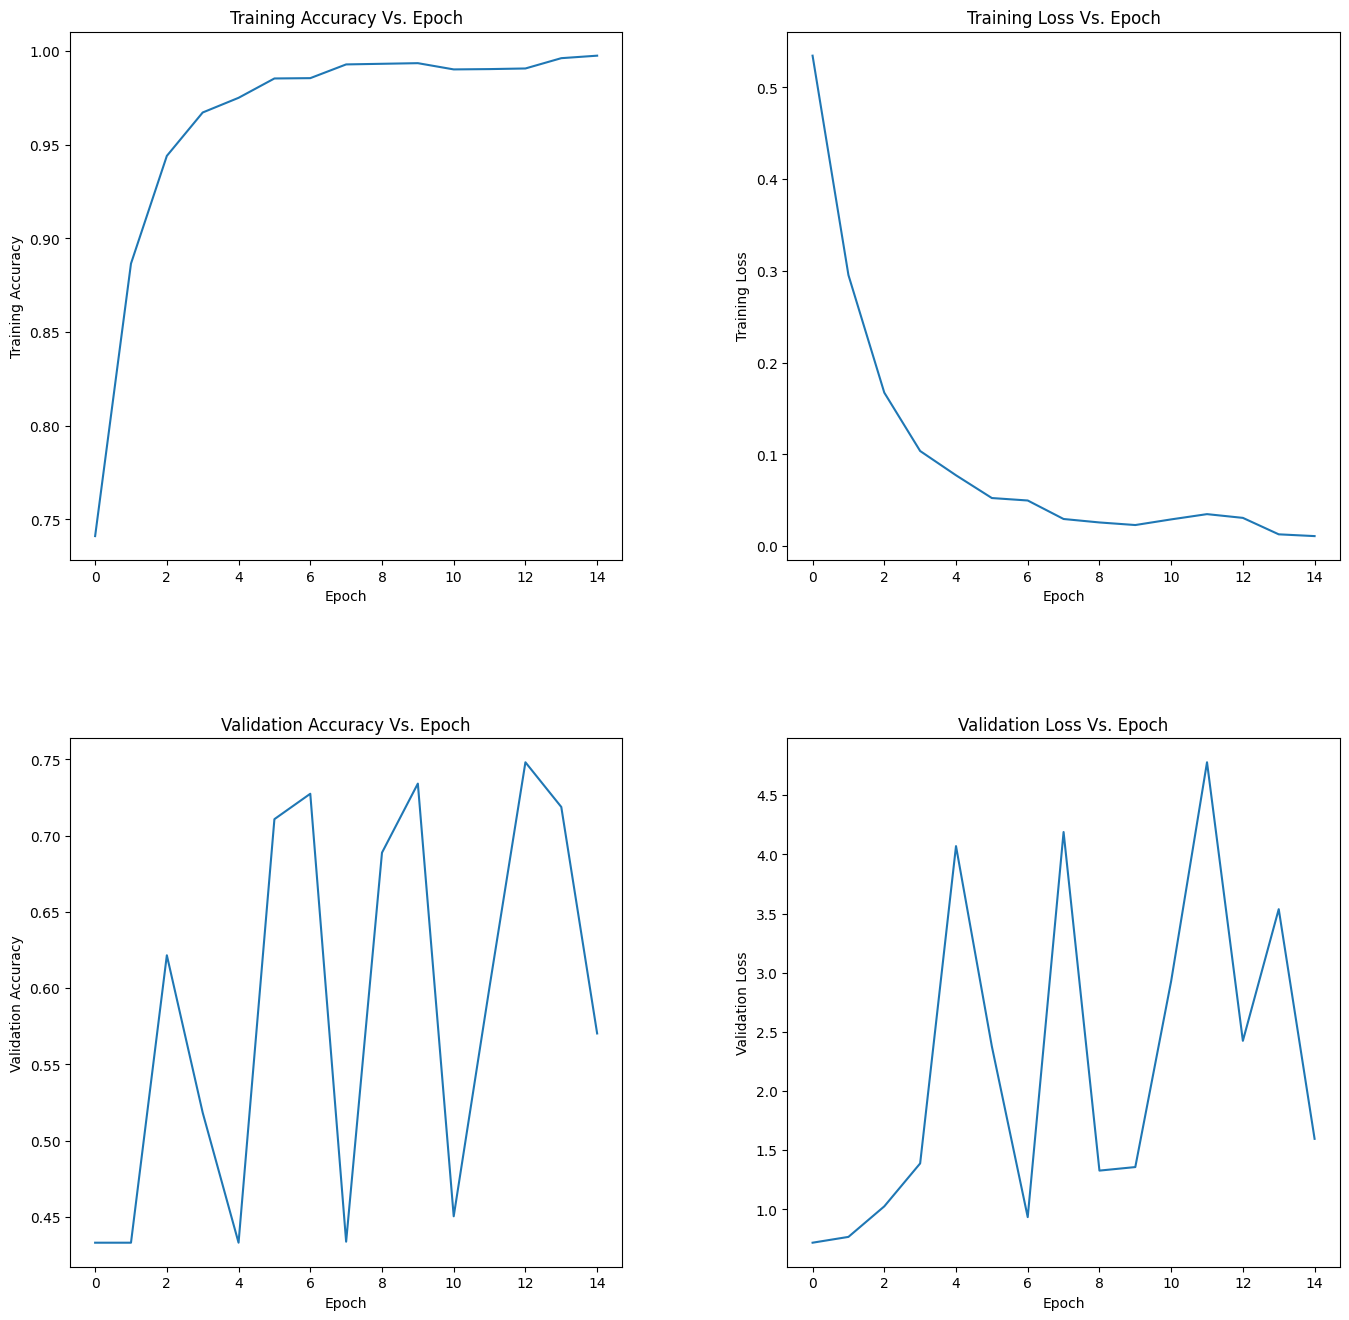

In [23]:
model_epochs=model2_epochs
plot_history(history2.history, startTime2, endTime2)

In this case as well, the model performs very well on the training data. Training accuracy climbs steadily eventually reaching 99.7%, and the training loss decreases consistently dropping to a very low value, indicating that the model has fit the training set extremely well.

However, the performance on the validation set tells a different story. Validation accuracy fluctuates significantly and never exceeds 75%, suggesting instability in how the model generalizes to new data.

While the validation loss starts off reasonably low, it shows a gradual upward trend, reinforcing the concern that the model is overfitting the training data rather than learning patterns that generalize well.

# Model 3

In this final approach, we aim to tune our model's hyperparameters in an effort to reduce the overfitting observed in the previous models.<br>
Specifically, we’ll focus on adjusting the learning rate (eta), testing values of 0.001, 0.005, and 0.01.

To keep the process efficient, the tuning will be conducted over a reduced number of epochs—just 10, compared to the longer training runs used in the earlier models.

In [24]:
model3 = Sequential()
model3.add(Embedding(input_dim = num_words+1, output_dim = 32))
model3.add(LSTM(64, return_sequences=True))

# Normalize to prevent overfitting
model3.add(BatchNormalization())
model3.add(LSTM(32))

# Normalize to prevent overfitting
model3.add(BatchNormalization())
model3.add(Dense(units=24, activation='relu'))

# Dropout layer randomly sets input units to 0 which helps prevent overfitting
model3.add(Dropout(0.25))
model3.add(Dense(units=1, activation='sigmoid'))

model3.build(input_shape=(None, 50))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 32)              │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 628,305 (2.40 MB)

 Trainable params: 628,113 (2.40 MB)

 Non-trainable params: 192 (768.00 B)

In [25]:
eta_to_try = [0.001, 0.005, 0.01]
model3_epochs = 10

current_best_model = (None, 0)
current_best_history = None
current_best_hp = None

model_accuracies = list()

In [27]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
startTime3 = time.time()
histories_list = []

for eta in eta_to_try:
    print("\n\nNow entering eta:", eta)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = eta, decay_steps = 10000, decay_rate = 0.9)
    # Make a learning rate schedule to prevent variance at the end of training.
    model3.compile(optimizer = Adam(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

    this_history = model3.fit(x_train, y_train, epochs = model3_epochs, validation_data=[x_val, y_val], callbacks = callbacks_list)
    histories_list.append(this_history.history)
    if this_history.history["accuracy"][-1] > current_best_model[1]:
        current_best_model = (model3, this_history.history["accuracy"][-1])
        current_best_history = this_history.history
        current_best_hp = eta
        
endTime3 = time.time()
print("Total HP optimization time:", round((endTime3 - startTime3) / 60, 3), "minutes")



Now entering eta: 0.001
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9988 - loss: 0.0060 - val_accuracy: 0.7688 - val_loss: 1.6032
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accuracy: 0.7728 - val_loss: 1.8652
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9969 - loss: 0.0083 - val_accuracy: 0.7655 - val_loss: 2.0635
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.7675 - val_loss: 1.6630
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.7628 - val_loss: 2.0406
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9984 - loss: 0.0033 - val_accuracy: 0.7668 - val_loss: 2.0972
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9978 - loss: 0.0035 - val_accuracy: 0.7662 - val_loss: 2.1828
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.999

**MODEL 3 RESULTS**

The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.999
Loss = 0.003
Validation Accuracy = 0.763
Validation Loss = 2.221


The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.999
Loss = 0.007
Validation Accuracy = 0.762
Validation Loss = 2.036


The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.996
Loss = 0.017
Validation Accuracy = 0.753
Validation Loss = 1.039




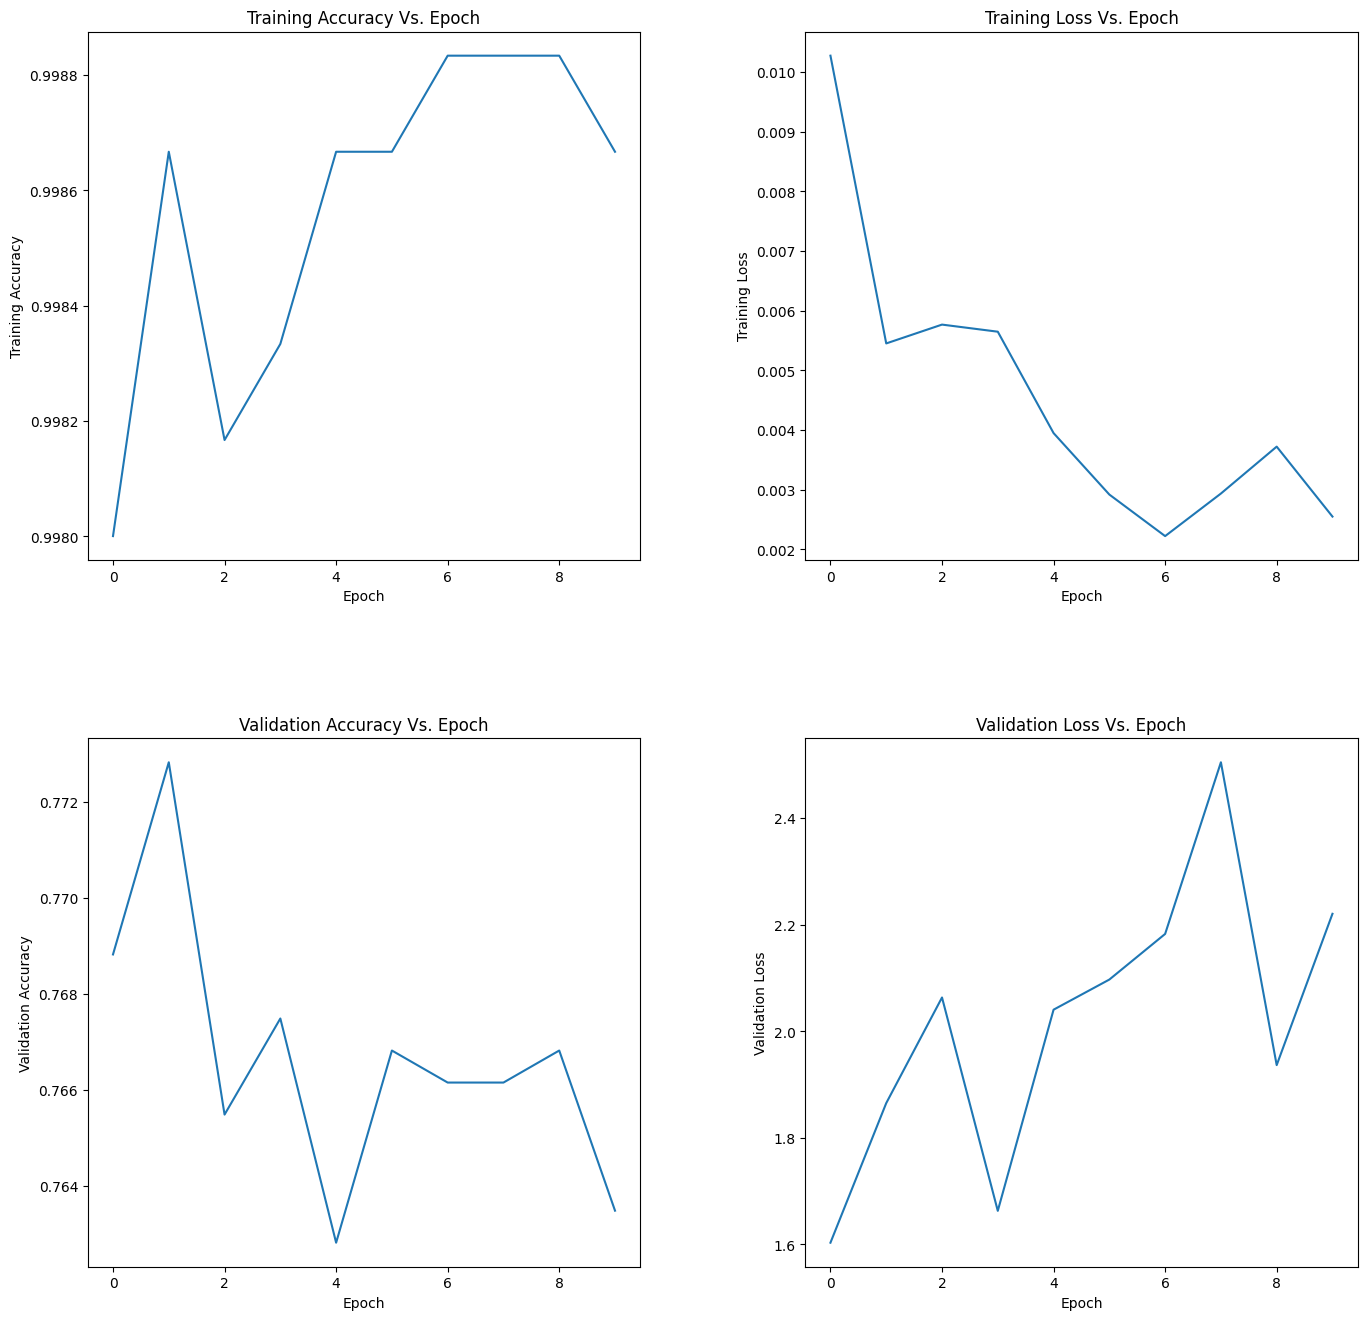

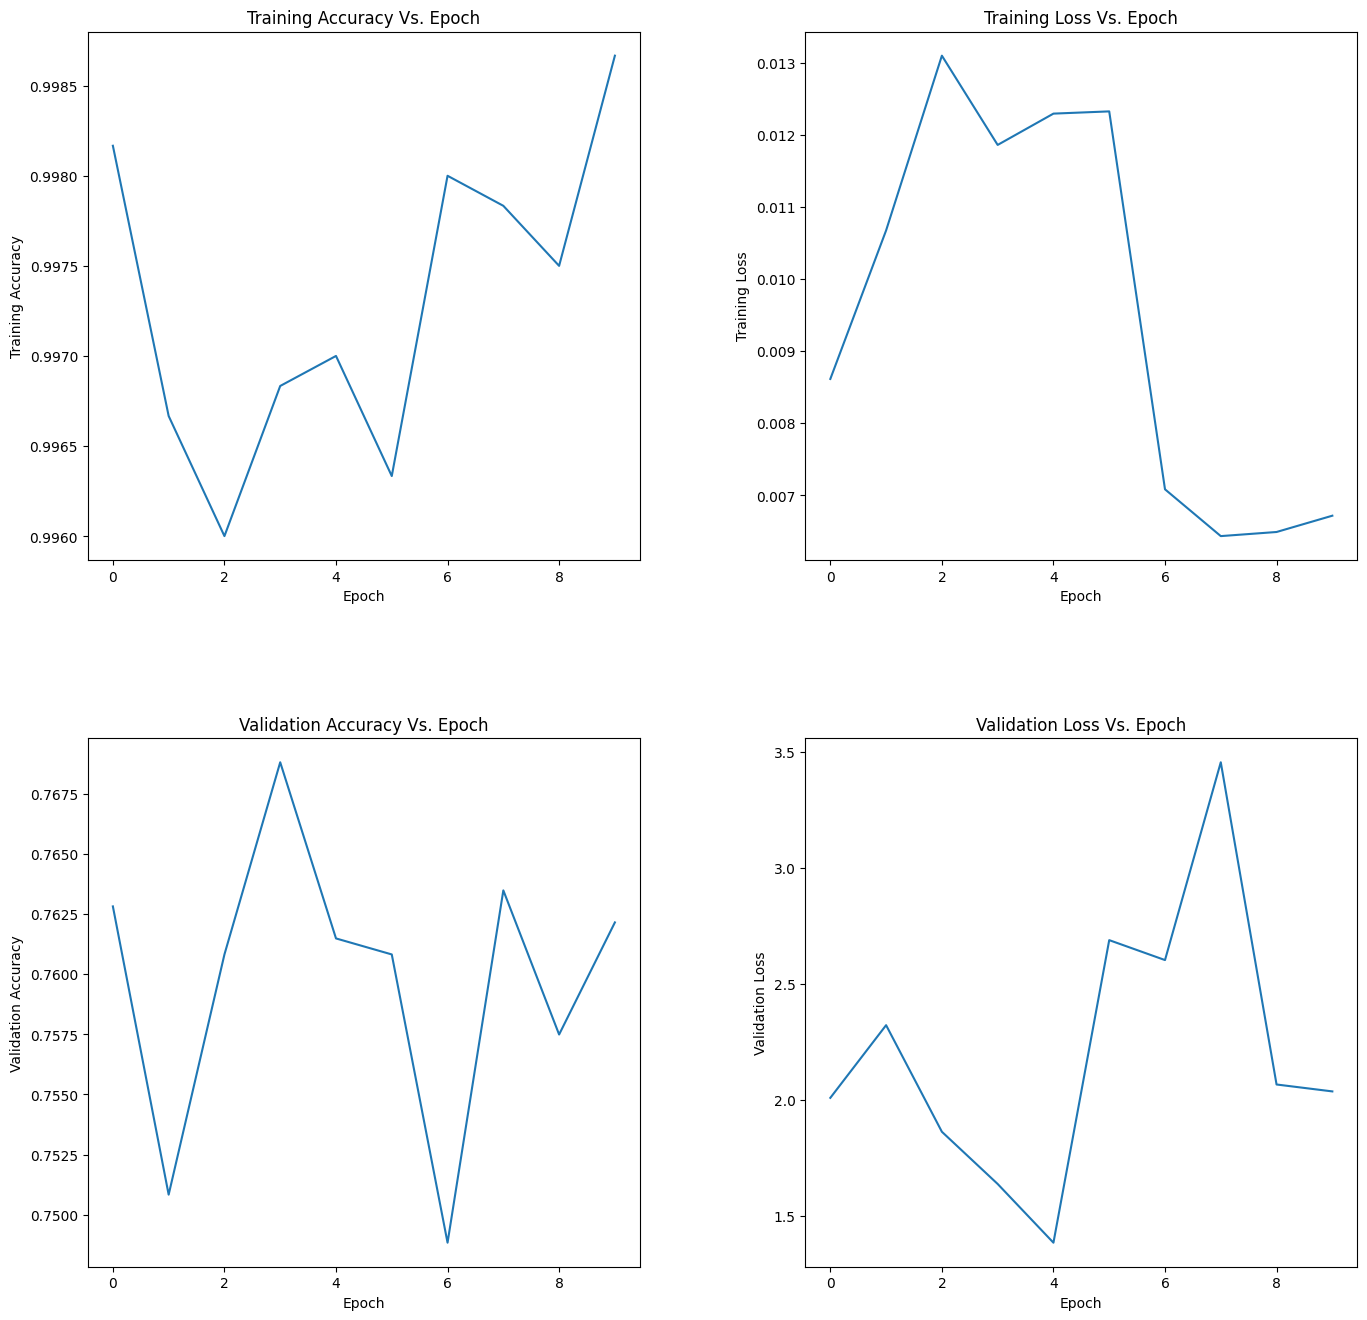

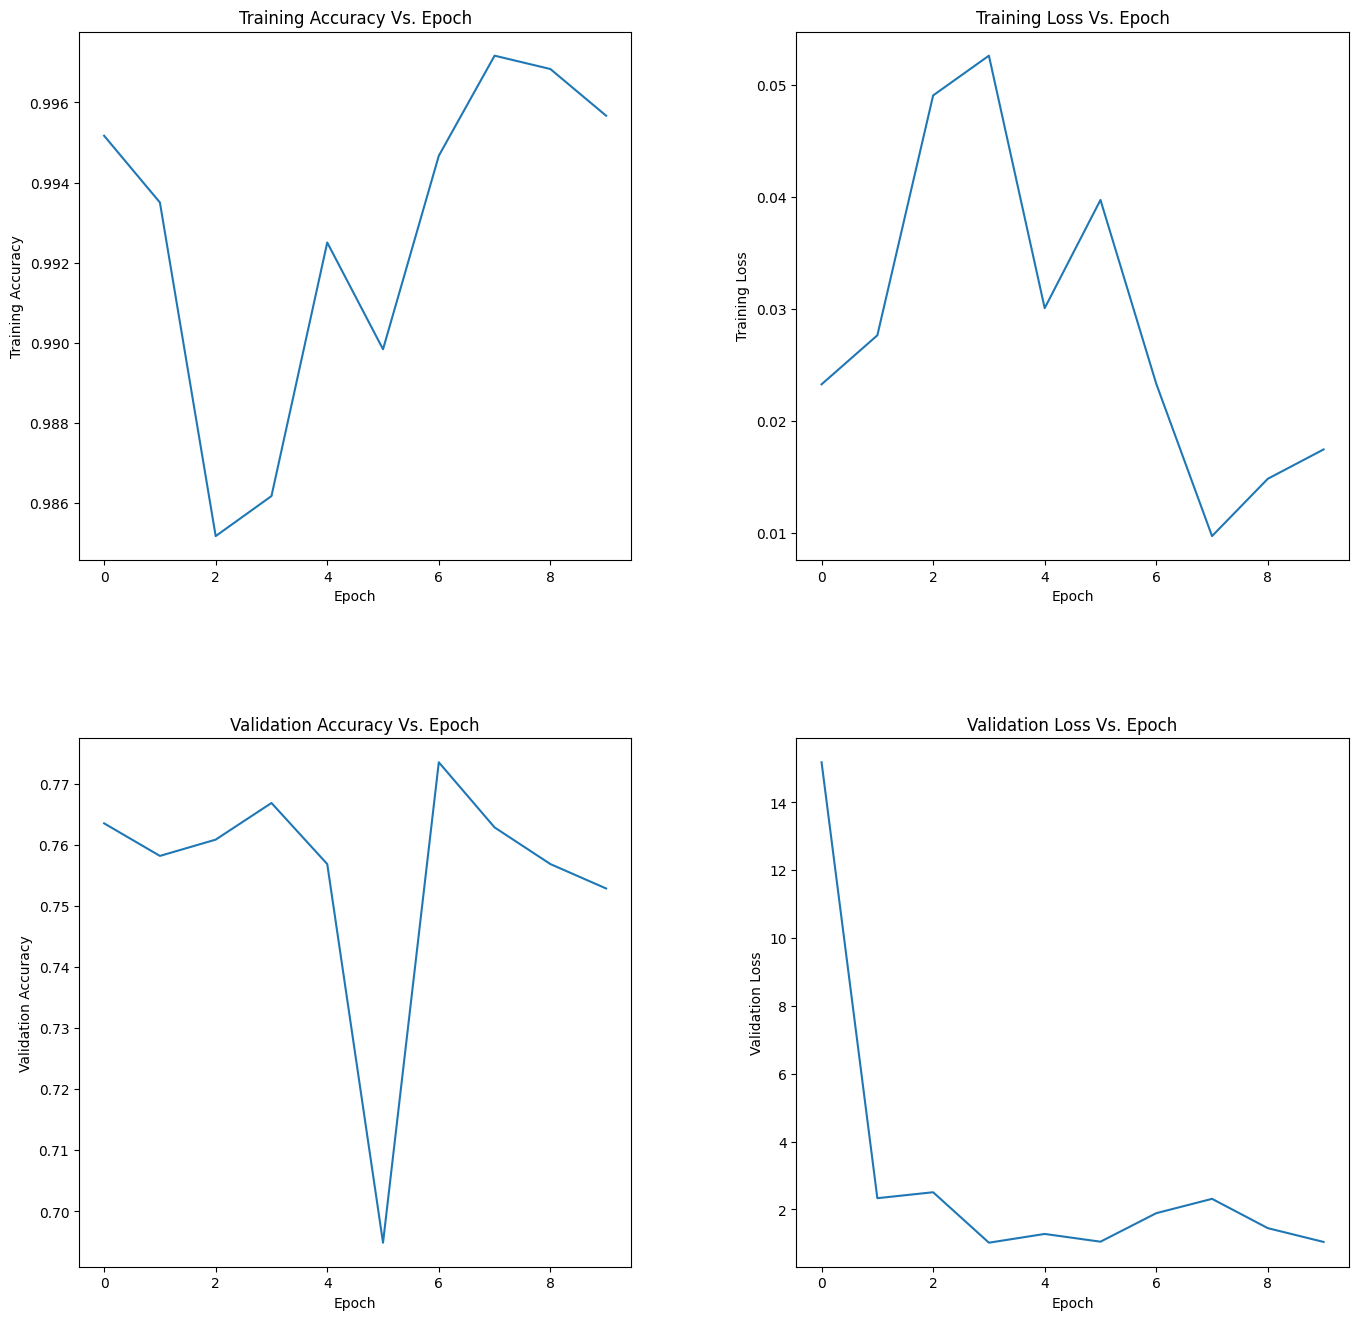

In [28]:
model_epochs=model3_epochs

for el in histories_list:
    plot_history(el)

After testing different learning rates, we observed that all three models achieved very high training accuracy, ranging from 98.6% to 99.9%, with correspondingly low training loss values. This confirms that each configuration was capable of fitting the training data effectively.

However, the validation performance reveals more complex insights. While the model with eta = 0.001 achieved near-perfect training accuracy and minimal loss, its validation accuracy remained low (73.4%), and validation loss was quite high, indicating significant overfitting.

The models with eta = 0.005 and 0.01 showed slightly lower training accuracy but improved validation performance, with the best validation accuracy (76.1%) achieved using eta = 0.01. This suggests that a slightly higher learning rate helped the model generalize better, even if it came at the cost of slightly higher training loss.

In summary, while all learning rates enabled the model to learn the training data well, eta = 0.01 struck the best balance between learning and generalization, making it the most effective choice among the tested options.

# **4. Conclusions**

Throughout this project, we implemented multiple models using LSTM layers and experimented with different architectures. Despite strong performance on the training set—often exceeding 99% accuracy—validation results consistently indicated overfitting, with validation accuracy becoming stable around 75–76%.

To address this, we conducted some hyperparameter tuning, adjusting the learning rate to improve generalization. While the model with a learning rate of 0.01 showed the best balance between training and validation performance, the gap between training and validation metrics remained significant.

In conclusion, we can assume that this model may not perform well when submitting predictions to Kaggle, as it continues to show signs of overfitting and struggles to generalize to unseen data. Further steps could include experimenting with additional regularization and alternative architectures.